# What?
In this notebook we will discuss about some topics on model selection in the presence of imabalanced datasets. The discussion can be guided by the following driving questions:
* What is the effect of class imbalance on different classification algorithms?
* Is class imbalance really a problem when there is enough data?
* What is the best benchmark model to start with? What does "best" actually mean in this situation?
* What can be done to mitigate the effect of imbalance on specific algorithms?

## How?
We intend to analyze the behavior (using some classification metrics) of different classification models under various imbalance scenarios
At this point we won't pay too much attention on the optimization of the models themselves. Rather, we will work with the model 'as-is' and compare them with the objective of finding the *best* benchmarking model.

# Imports

In [1]:
# basics
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Any, List, Dict

# plotting
import matplotlib
import plotly.express as px
from matplotlib import pyplot as plt

# sklearn
from sklearn.datasets import make_classification

# Auxiliary Functions

In [2]:
def bootstrap_samples(y_true: List, y_pred: List, n_batches: int = 100) -> List:
    """Get bootstrap samples

    Parameters
    ----------

    y_true : array_like, shape = [n_samples]
        true events labels

    y_pred : array_like, shape = [n_samples]
        events predictions

    n_batches : int, optinal
        number of bootstrap samples, default = 100

    Returns
    -------

    preds_samples : array_like, shape = [n_samples, [n_batches, 2]]
        list of bootstrap samples from y_true and y_preds
    """
    # y_true = pd.Series(y_true, name='y_true')
    # y_pred = pd.Series(y_pred, name='y_pred')
    # df_preds = pd.concat((y_true, y_pred), axis=1)
    df_preds = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    n_samples = len(y_true)
    preds_samples = []
    for i in np.arange(n_batches):

        df_preds_resample = df_preds.sample(n_samples, replace=True)

        y_true_resample = df_preds_resample['y_true'].values
        y_pred_resample = df_preds_resample['y_pred'].values

        preds_samples.append({'y_true': y_true_resample,
                              'y_pred': y_pred_resample})

    preds_samples = preds_samples

    return preds_samples

In [3]:
def delinquency_curve(y_true, y_score, pointwise=True):
    """ Delinquency curve.

    The delinquency curve is curve that shows the default rate in function of
    the approval rate. With this curve is possible to have a clear view of a
    credit operation and its characteristics for all possible scenarios.

    Parameters
    ----------

    y_true : array, shape = [n_samples]
        Correct labels for given dataset.

    y_score : array, shape = [n_samples]
        Predict scores for the given dataset.

    pointwise : bool, optional
        boolean indicating whether to compute pointwise delinquency curve.

    Returns
    -------
    approval_rate: array, shape = [n_samples+1] if pointwise=True else [21]
        Array containing the approval rates used to compute the default_rate
        curve.
    default_rate: array, shape = [n_samples+1] if pointwise=True else [21]
        Default rate values for the approval rates provided in approval_rate.
        default_rate[i] is the ratio of events registered in the best
        approval_rate[i]% of scores.

    """
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    assert len(y_true) == len(y_score), F"y_true and y_score doesn't have " \
        F"the same length. len(y_true) = " \
        F"{len(y_true)}, len(y_score) = " \
        F"{len(y_score)}"

    indexsort = np.argsort(y_score)[::-1]
    y_approved = y_true[indexsort].copy()

    if pointwise:
        list_index = np.arange(1, len(y_approved)+1)
        approval_rate = np.append(0, list_index/len(list_index))
        default_rate = np.append(0, y_approved.cumsum()/list_index)
    else:
        approval_rate = np.linspace(0, 1, 21)
        n = len(y_true)

        default_rate = np.array([y_approved[:int(np.floor(i * n))].mean()
                                 if (y_approved[:int(np.floor(i * n))]
                                     .size)
                                 else 0 for i in approval_rate])
    return approval_rate, default_rate

In [4]:
def compute_metrics(y_true: List, y_proba: List, n_round: int = 2) -> pd.DataFrame:
    """Computes several classification metrics at once
    Parameters
    ----------
    y_true : array_like, shape = [n_samples]
        true events labels

    y_pred : array_like, shape = [n_samples]
        events predictions

    n_round : int, optional
        number o decimals to round gini and ks metrics
    Returns
    -------
    metrics: pd.DataFrame
    """
    metrics = {}
    # ROC AUC
    metrics['roc_auc'] = np.round(roc_auc_score(y_true, y_proba), n_round)
    # GINI
    metrics['gini'] = 2 * metrics['roc_auc'] - 1
    # Average precision
    metrics['avg_precision'] = np.round(average_precision_score(y_true, y_proba), n_round)
    # ROC Curve
    fpr, tpr, thresholds_roc = roc_curve(y_true = y_true, y_score = y_proba)
    metrics['roc_curve'] = {'fpr': fpr,
                            'tpr': tpr, 
                            'thresholds': thresholds_roc}
    # Precision-Recall curve
    precision, recall, thresholds_pr = precision_recall_curve(y_true = y_true, probas_pred = y_proba)
    metrics['pr_curve'] = {'precision' : precision,
                            'recall': recall,
                            'thresholds': thresholds_pr}
    # Delinquency curve
    d_curve_p = delinquency_curve(y_true = y_true, y_score = 1 - y_proba, pointwise= True)
    d_curve_agg = delinquency_curve(y_true = y_true, y_score = 1 - y_true, pointwise = False)
    metrics['d_curve_pointwise'] = d_curve_p
    metrics['d_curve_agg'] = d_curve_agg

    return metrics


In [5]:
def compute_metrics_bootstrap(y_true, y_pred, n_batches=100):
    """computes frequently used metrics from bootstramp samples

    Parameters
    ----------

    y_true : array_like, shape = [n_samples]
        true events labels

    y_pred : array_like, shape = [n_samples]
        events predictions

    n_batches : int, optinal
        number of bootstrap samples, default = 100

    Returns
    -------

    metrics_summary : dict
        dictionary containig statistics of gini, ks, d_curve and c_curves
    """
    preds_samples = bootstrap_samples(y_true, y_pred, n_batches)

    df_metrics = pd.DataFrame([compute_metrics(y['y_true'],
                                                     y['y_pred'])
                              for y in preds_samples])

    approval_rate_p = df_metrics['d_curve_pointwise'].iloc[0][0]
    default_rate_mean_p = df_metrics['d_curve_pointwise'].apply(
        lambda x: x[1]).mean()
    default_rate_std_p = df_metrics['d_curve_pointwise'].apply(
        lambda x: x[1]).values.std()
    d_curve_mean_p = (approval_rate_p, default_rate_mean_p)
    d_curve_std_p = (approval_rate_p, default_rate_std_p)

    approval_rate_agg = df_metrics['d_curve_agg'].iloc[0][0]
    default_rate_mean_agg = df_metrics['d_curve_agg'].apply(
        lambda x: x[1]).mean()
    default_rate_std_agg = df_metrics['d_curve_agg'].apply(
        lambda x: x[1]).values.std()
    d_curve_mean_agg = (approval_rate_agg, default_rate_mean_agg)
    d_curve_std_agg = (approval_rate_agg, default_rate_std_agg)

    metrics_stats = df_metrics[['roc_auc',
                                'gini',
                                'avg_precision',
                                # 'ks'
                                ]].apply([np.mean, np.std])

    metrics_summary = {'d_curve_pointwise': {'d_curve_mean': d_curve_mean_p,
                                             'd_curve_std': d_curve_std_p},
                       'd_curve_agg': {'d_curve_mean': d_curve_mean_agg,
                                       'd_curve_std': d_curve_std_agg},
                       'metrics_stats': metrics_stats,
                       'df_metrics': df_metrics}
    return metrics_summary

In [6]:
def clean_ax(ax, all = False):
    """Clean spines of a matplotlib axis"""
    if all:
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)    
    ax.spines["top"].set_visible(False)
    return ax

# Data
We will write a function that generates synthetic binary classification data allowing for various class imbalance levels

In [7]:
def create_imbalanced_binary_classification(n_samples: int = 1000, 
                                            n_features: int = 4,
                                            n_informative: int = None, 
                                            imbalance: float = 0.1,
                                            random_state: int = 42,
                                            class_sep : float = 1.0) -> pd.DataFrame:
    """Creates an imbalanced dataset for binary classification
    Parameters
    ----------
    n_samples: int, default = 1000,
            number of samples to generate
    n_features: int default = 4,
            number of features (not all are informative)
    n_informative: int default = None,
            number of informative features
            if none is specified floor(n_features/2) 
            will be taken
    imbalance: float, default = 0.1
            proportion of the minority class
    random_state: int, default = 42
    class_sep: float, default = 1.0
        The larger the value the easier the classification task
    Returns
    -------
    data: pd.DataFrame,
        dataframe with n_features + 1 columns
    """
    if n_informative == None:
        n_informative = int(n_features/2)
    weights = [1 - imbalance, imbalance]
    X, y = make_classification(n_samples = n_samples,
                                n_features = n_features,
                                n_classes=2,
                                n_informative = n_informative,
                                weights = weights,                
                                random_state = random_state,
                                class_sep = class_sep)
    column_names = [ f'feature_{i}' for i in np.arange(n_features)]      
    data = pd.concat([pd.DataFrame(X, columns = column_names), pd.DataFrame(y, columns = ['target'])], axis = 1)
    return data, column_names

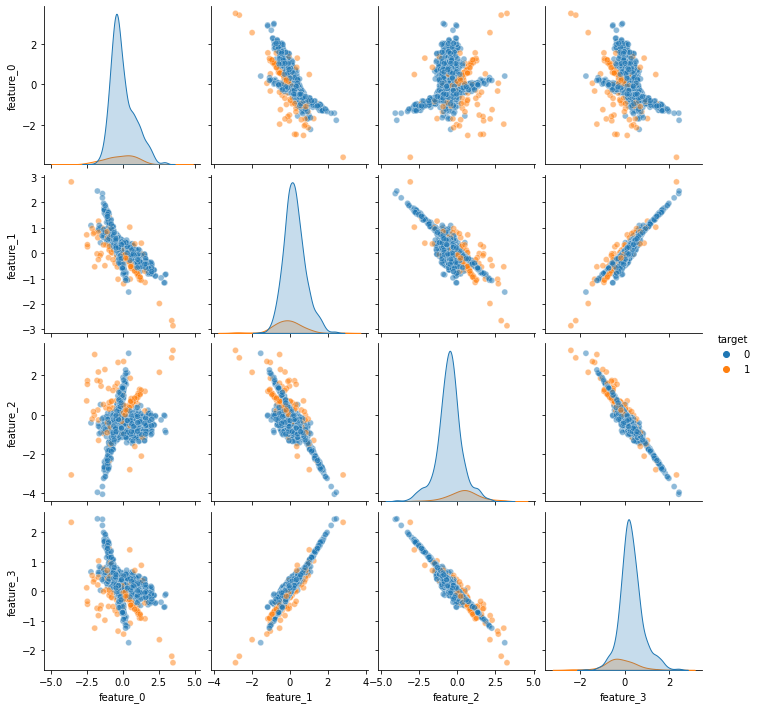

In [8]:
n_samples = 10**3
n_features = 4
imbalance = 0.1
n_informative = 2
class_sep = 0.5
data, column_names = create_imbalanced_binary_classification(n_samples = n_samples, 
                                        n_features = n_features,
                                        n_informative = n_informative,
                                        imbalance = imbalance,
                                        class_sep = class_sep)
sns.pairplot(data, hue = 'target', plot_kws = {'alpha' : 0.5})


# Model comparison
In this section we will compare the performance (and other aspects) of different models under different class imbalance scenarios.
We will start by analyzing the performance dependence on the class imbalance index which we define as being the minority class ratio or *Prevalence*. If we call $P$ and $N$ the number of positive and negative observations, the prevalance is given by:
$$\text{Prevalence} = \dfrac{P}{P+N}$$

In [9]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, matthews_corrcoef,  precision_recall_curve,\
                            average_precision_score, f1_score


Let us see how the performance changes for different imbalance ratios:

In [10]:
n_samples = 10**5
n_features = 4
n_informative = 2
class_sep = 0.5
metrics = {}
fit_time = {}
imbalances = [0.5, 0.3, 0.2, 0.1, 0.05, 0.01, 5e-3, 1e-4]
random_state = 42
for imbalance in imbalances:
    print(f'Minority class proportion: {imbalance}')
    metrics[imbalance] = {}
    # Create dataset
    data, column_names = create_imbalanced_binary_classification(n_samples = n_samples, 
                                        n_features = n_features,
                                        n_informative = n_informative,
                                        imbalance = imbalance,
                                        class_sep = class_sep)
    # Train test split
    X, y = data[column_names], data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, stratify = y)
    
    # Logistic Regression
    print('\tLog Regression ...')
    lr_pipeline = Pipeline([('scaler', StandardScaler()),
                            ('logreg', LogisticRegression())])
    lr_pipeline.fit(X_train, y_train)
    y_proba_lr = lr_pipeline.predict_proba(X_test)
    # metrics[imbalance]['logreg'] = compute_metrics(y_true = y_test, y_proba = y_proba_lr[:,1])
    metrics[imbalance]['logreg'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_lr[:,1])
    
    # Decision Tree
    print('\tDecision Tree ...')
    dt_clf = DecisionTreeClassifier()
    dt_clf.fit(X_train, y_train)
    y_proba_dt = dt_clf.predict_proba(X_test)
    # metrics[imbalance]['dt'] = compute_metrics(y_true = y_test, y_proba= y_proba_dt[:,1])
    metrics[imbalance]['dt'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_dt[:,1])

    # Random Forest
    print('\tRandom Forest ...')
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    y_proba_rf = rf_clf.predict_proba(X_test)
    metrics[imbalance]['rf'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_rf[:,1])

    # Naive Bayes
    print('\tNaive Bayes ...')
    nb_clf = RandomForestClassifier()
    nb_clf.fit(X_train, y_train)
    y_proba_nb = nb_clf.predict_proba(X_test)
    metrics[imbalance]['nb'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_nb[:,1])

    # Gradient Boosting Machine
    print('\tGradient Boosting ...')
    gb_clf = HistGradientBoostingClassifier()
    gb_clf.fit(X_train, y_train)
    y_proba_gb = gb_clf.predict_proba(X_test)
    metrics[imbalance]['gb'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_gb[:,1])

    # Dummy Classifier
    print('\tDummy Classifier ...')
    dummy_clf = DummyClassifier()
    dummy_clf.fit(X_train, y_train)
    y_proba_dummy = dummy_clf.predict_proba(X_test)
    metrics[imbalance]['dummy'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_dummy[:,1])

    # # SVM Classifier
    # print('Support Vector Machine ...')
    # svm_pipeline = Pipeline([('scaler', StandardScaler()),
    #                         ('svc', SVC(gamma = 'auto',
    #                                     probability= True))])
    # svm_pipeline.fit(X_train, y_train)
    # y_proba_svm = svm_pipeline.predict_proba(X_test)
    # metrics[imbalance]['svm'] = compute_metrics_bootstrap(y_true= y_test, y_pred = y_proba_svm[:,1])

print('end')

Minority class proportion: 0.5
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...
Minority class proportion: 0.3
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...
Minority class proportion: 0.2
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...
Minority class proportion: 0.1
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...
Minority class proportion: 0.05
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...
Minority class proportion: 0.01
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	Naive Bayes ...
	Gradient Boosting ...
	Dummy Classifier ...
Minority class proportion: 0.005
	Log Regression ...
	Decision Tree ...
	Random Forest ...
	

In [11]:
def plot_metric_evolution(metrics: Dict, 
                          model_name: str,
                          metric_4_display: str = 'roc_auc',
                          color: str = 'purple', 
                          ax: matplotlib.axis = None) -> matplotlib.axis:
    """
    Plots the imbalance-evolution of classification metrics

    """
    labels = {'logreg': 'Logistic Regression',
              'dt': 'Decision Tree',
              'rf': 'Random Forest',
              'nb': 'Naive Bayes',
              'gb': 'Gradient Boosting',
              'dummy': 'Dummy Classifier' }
    if ax == None:
        f, ax = plt.subplots(dpi = 100)
    metrics_mean = [metrics[x][model_name]['metrics_stats'][metric_4_display]['mean'] for x in metrics.keys()]
    metrics_std = [metrics[x][model_name]['metrics_stats'][metric_4_display]['std'] for x in metrics.keys()]
    x = range(len(metrics.keys()))
    ax.plot(metrics_mean, marker = '.', linestyle = '--',
            color = color, label = labels[model_name],
            alpha = 0.6)
    ax.fill_between(x = x, 
                    y1 = np.subtract(metrics_mean, metrics_std), 
                    y2 =np.add(metrics_mean, metrics_std),
                    alpha = 0.3, facecolor = color)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics.keys())
    ax.set_xlabel('Minority class proportion')
    return ax

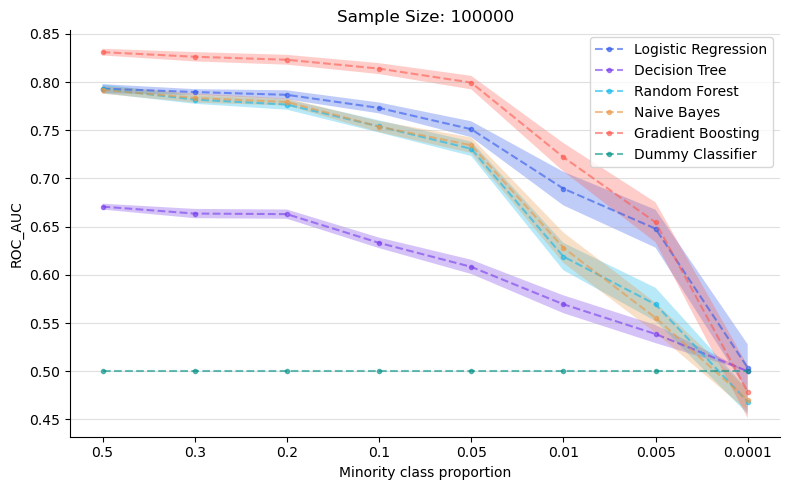

In [14]:
metric_4_display = 'roc_auc'
colors = {'logreg': '#2F58EB',
          'dt': '#773BEB',
          'rf': '#12B8EB',
          'nb': '#EB9846',
          'gb': '#FC5A50',
          'dummy': '#029386'}
f, ax = plt.subplots(dpi = 100, figsize = (8,5))
for model_name, color in colors.items():
    plot_metric_evolution(metrics, model_name, metric_4_display= metric_4_display, color = color, ax = ax)
ax.legend(loc = 'best')
ax.grid(True, axis = 'y', alpha = 0.4)
ax.set_ylabel(metric_4_display.upper())
ax.set_title(f'Sample Size: {n_samples}')
clean_ax(ax)
f.tight_layout()

At first sight the Logistic Regression performance dependence on imbalance is very similar to the Gradient Boosting Machine, which makes the Logisitic Regression a good candidate for a benchmark model. What other quantities should we look at? 
* Training time
* model complexity